In [1]:
from builtins import RuntimeWarning
from builtins import NotImplementedError
import os, sys
import numpy as np
import PIL
from PIL import Image
import warnings
import random
import pickle

import torch
import json
import torch.utils.data
import torchvision
from torchvision import transforms as tfms
import torch, logging
import torch.nn as nn

import matplotlib.pyplot as plt
logging.disable(logging.WARNING)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode

PIL.Image.MAX_IMAGE_PIXELS = 1000000000
PIL.Image.warnings.simplefilter('error', PIL.Image.DecompressionBombWarning)

# For Aux Annotation in CIRR
WORD_REPLACE = {
  '[c] None existed': 'noneexisted',
  '[cr0] Nothing worth mentioning': 'nothingworth',
  '[cr1] Covered in query': 'coveredinquery',
}

In [27]:
## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer, CLIPProcessor, CLIPModel
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

# Initialize device
device = "cuda:4" if torch.cuda.is_available() else "cpu"
print("Using", device)

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("clip-vit-large-patch14").to(device)

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)

# CLIPImage Processor
processor = CLIPProcessor.from_pretrained("clip-vit-large-patch14")
image_encoder = CLIPModel.from_pretrained("clip-vit-large-patch14")

Using cuda:4


In [28]:
class BaseDataset(torch.utils.data.Dataset):
  """Base class for a dataset.
  This portion is based on the TIRG implementation,
  see https://github.com/google/tirg.
  """

  def __init__(self):
    super(BaseDataset, self).__init__()
    self.imgs = []
    self.test_queries = []

    # self.logger = logger
    # self.logger.write(''); self.logger.write('Start init BaseDataset class...')
  
  def get_loader(self, batch_size, shuffle=False, drop_last=False):
    # self.logger.write('\nNum_worker: %i, pin_memory: %s' % (num_workers, str(pin_memory)))
    return torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, collate_fn=lambda i: i)

  def get_all_texts(self):
    raise NotImplementedError
  
  def get_test_queries(self):
    return self.test_queries if self.split != 'train' else self.train_queries

  def generate_random_query_target(self):
    raise NotImplementedError
  
  def get_img(self, idx, raw_img=False):
    raise NotImplementedError

  def __getitem__(self, idx):
    return self.generate_random_query_target()

In [4]:
class CIRR(BaseDataset):
  """ The CIRR dataset.
  This is partially based on TIRG implementation and Fashion-IQ implementation
  see https://github.com/google/tirg, https://github.com/XiaoxiaoGuo/fashion-iq.
  """
  def __init__(self, path, processor, image_encoder, tokenizer, text_encoder, split='train', val_loader=None, device = "cuda:7"):
    super(CIRR, self).__init__()
    '''stable dataset version, DO NOT CHANGE unless you are sure
    corresponding dataset version can be found in our repository
    https://github.com/Cuberick-Orion/CIRR/tree/cirr_dataset
    '''

    self.device = "cuda:4" if torch.cuda.is_available() else "cpu"
    
    self.processor = processor
    self.image_encoder = image_encoder

    self.tokenizer = tokenizer
    self.text_encoder = text_encoder
    
    self.version = 'rc2' 
      
    assert split in ['train', 'val', 'test1']
    self.split = split

    assert val_loader in [None, 'img+txt', 'img'] # if None, then proceed as original, if otherwise, return will be different
    self.val_loader = val_loader

    self.img_path = path
    data = { # hold all data read from json files
        'image_splits': {},
        'captions': {},
        'captions_ext': {} 
    }
     # load the corresponding json files
    for subfolder_name in data:
      print(subfolder_name)
      print(os.listdir(path + '/' + subfolder_name))
      for json_name in os.listdir(path + '/' + subfolder_name):
        if (split == 'train' and 'train' in json_name) \
        or (split == 'val' and 'val' in json_name) \
        or (split == 'test1' and 'test' in json_name):
          json_load = json.load(open(path + '/' + subfolder_name + '/' + json_name))
          data[subfolder_name][json_name] = json_load
    
    imgs = []
    asin2id = {}; id2asin=[]
    for json_name in data['image_splits']:
      for asin_,img_path_ in data['image_splits'][json_name].items():
        asin2id[asin_] = len(imgs)
        id2asin.append(asin_)
        imgs += [{
          'asin': asin_,
          'img_feat_res152_path': os.path.join(self.img_path, 'img_feat_res152', img_path_.replace('.png','.pkl')),
          'captions': [asin2id[asin_]],
          'img_raw_path': os.path.join(self.img_path, 'img_raw', img_path_), #! Uncomment this line if raw img is downloaded
        }]

    # process queries from loaded data
    queries = []
    for json_name in data['captions']:
      for query in data['captions'][json_name]:
        if self.split != 'test1':
          query['source_id'] = asin2id[query['reference']]
          query['target_id'] = asin2id[query['target_hard']]
          query['captions'] = [query['caption']]
          query['target_soft_id'] = {asin2id[kkk]:vvv for kkk,vvv in query['target_soft'].items()}
          queries += [query]
        else:
          query['source_id'] = asin2id[query['reference']]
          query['captions'] = [query['caption']]
          queries += [query]

    # add Aux Annoation from cap.ext
    queries_temp = {qqq['pairid']:qqq for qqq in queries} 
    for kkk,qqq in queries_temp.items():
      queries_temp[kkk]['caption_extend'] = None
    for json_name in data['captions_ext']:
      for query in data['captions_ext'][json_name]:
        query_cap_ext_ = {}
        for kkk_,vvv_ in query['caption_extend'].items():
          if vvv_ in WORD_REPLACE.keys():
            query_cap_ext_[kkk_] = WORD_REPLACE[vvv_]
          else:
            query_cap_ext_[kkk_] = vvv_
        queries_temp[query['pairid']]['caption_extend'] = query_cap_ext_
    queries = [qqq for kkk,qqq in queries_temp.items()]
   
    self.data = data
    self.imgs = imgs
    self.asin2id = asin2id; self.id2asin = id2asin
    self.queries = queries

    # prepare a copy of test_queries from queries
    if split in ['train', 'val']:
      self.test_queries = [{
        'source_img_id': query['source_id'],
        'target_img_id': query['target_id'],
        'source_caption': query['source_id'],
        'target_caption': query['target_id'],
        'target_caption_soft': query['target_soft_id'],
        'set_member_idx': [self.asin2id[ii] for ii in query['img_set']['members'] if ii != query['reference']],
        'mod': {'str': query['captions'][0], **query['caption_extend']},
        'caption_ext': query['caption_extend'],
        'pairid': query['pairid']
      } for _, query in enumerate(queries)]
    elif split == 'test1': 
      self.test_queries = [{
        'source_img_id': query['source_id'],
        'source_caption': query['source_id'],
        'set_member_idx': [self.asin2id[ii] for ii in query['img_set']['members'] if ii != query['reference']],
        'mod': {'str': query['captions'][0], **query['caption_extend']},
        'caption_ext': query['caption_extend'],
        'pairid': query['pairid']
      } for _, query in enumerate(queries)]

  def __len__(self):
    if self.split == 'train' and not self.val_loader: # in training
      return len(self.imgs)
    else: # in validation/test
      if self.val_loader == 'img+txt':
        return len(self.test_queries)
      elif self.val_loader == 'img':
        return len(self.imgs)

  def __getitem__(self, idx):
      generated_ = self.generate_random_query_target()
      return self.image_enc(generated_['source_image_data']), self.image_enc(generated_['target_image_data']), self.text_enc(generated_['mod']['str'])
  
  def get_triplet(self, idx):
      generated_ = self.generate_random_query_target()
      return {'source_image':generated_['source_image_data'][0],
              'source_image_embeddings':self.image_enc(generated_['source_image_data']),
              'target_image':generated_['target_image_data'][0],
              'target_image_embeddings':self.image_enc(generated_['target_image_data']),
              'caption':generated_['mod']['str'],
              'caption_embeddings':self.text_enc(generated_['mod']['str'])}

  def image_enc(self, images):
      input = self.processor(images = images, return_tensors = "pt").to(self.device)
      return self.image_encoder.get_image_features(**input)

  def text_enc(self, prompts, maxlen=None):
      '''
      A function to take a texual prompt and convert it into embeddings
      '''
      if maxlen is None: maxlen = self.tokenizer.model_max_length
      inp = self.tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
      return self.text_encoder(inp.input_ids.to(self.device))[0]

  def get_imgs_in_set(self, set_member_idx):
    if not set_member_idx is None:
        img_feats = []
        img_feat_ = np.stack([self.get_img(d) for d in set_member_idx])
        img_feat_ = torch.from_numpy(img_feat_).float()
        img_feats.append(img_feat_)
        return img_feats
    else:
        return None
  
  def generate_random_query_target(self):
    query_idx = random.choice(range(len(self.queries)))
    query = self.queries[query_idx]
    
    mod_str = query['captions'][0]
    mod_str_ext = query['caption_extend'] # The Aux Annotation
    
    other_set_member_asin = [ii for ii in query['img_set']['members'] if ii != query['reference']]
    other_set_member_idx = [self.asin2id[ii] for ii in other_set_member_asin]

    target_soft_within_set = {kkk:vvv for kkk,vvv in query['target_soft'].items() if kkk in query['img_set']['members'] and kkk != query['reference']} # only consider things in set, filter out target == reference image which is just mistakes
    
    random_stageI_idx = None

    return {
      'source_image_id': query['source_id'],
      'target_image_id': query['target_id'],
      'source_image_data': [self.get_img(query['source_id'])],
      'target_image_data': [self.get_img(query['target_id'])],
      'mod': {'str': mod_str, **mod_str_ext},
      'target_caption': query['target_id'],
    }
  
  def get_img(self, idx):
      img_path = self.imgs[idx]['img_raw_path']
      with open(img_path, 'rb') as f:
        img = PIL.Image.open(f)
        img = img.convert('RGB')
        return img

dataset = CIRR('./data/cirr', 
               processor = processor,
               image_encoder = image_encoder,
               tokenizer = tokenizer,
               text_encoder = text_encoder,
               device = device)

print(len(dataset))

image_splits
['split.rc2.train.json', 'split.rc2.test1.json', 'split.rc2.val.json']
captions
['cap.rc2.val.json', 'cap.rc2.test1.json', 'cap.rc2.train.json']
captions_ext
['cap.ext.rc2.val.json', 'cap.ext.rc2.test1.json', 'cap.ext.rc2.train.json']
16939


Change to a larger fur maned Chow Chow breed dog, change to only grass in background
Change pilow colors to green and yellow, put one on stool, and add flowers and books.
Make the top of the bottle red.
a group of ten different people instead of two guys among cardboard boxes


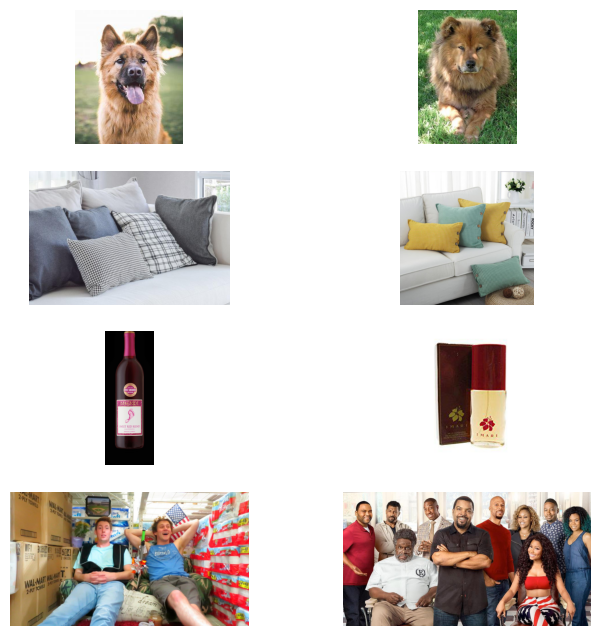

In [5]:
# Util Functions
def visualize_data(num_triplets = 4):
  fig, ax = plt.subplots(num_triplets, 2, figsize = (8, 8))
  for i in range(num_triplets):
    data = dataset.generate_random_query_target()
    ax[i][0].imshow(data['source_image_data'][0])
    ax[i][1].imshow(data['target_image_data'][0])
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    print(data['mod']['str'])

visualize_data()

In [6]:
class CIRPipeline(torch.nn.Module):
    def __init__(self, tokenizer, text_encoder, vae, scheduler, unet, processor, image_encoder, device):
        super(CIRPipeline, self).__init__()
        self.device = device
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder.to(device)
        self.vae = vae.to(device)
        self.scheduler = scheduler
        self.unet = unet.to(device)
        self.processor = processor
        self.image_encoder = image_encoder.to(device)
        
        # Freeze all other models        
        for param in self.text_encoder.parameters():
            param.requires_grad = False
        
        for param in self.vae.parameters():
            param.requires_grad = False
            
        for param in self.unet.parameters():
            param.requires_grad = False

        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.text_layer = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 768)
        ).to(device)

        self.image_layer = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 768)
        ).to(device)

        self.combined_layer = nn.Sequential(
            nn.Linear(78, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 77)
        ).to(device)        
            
    def load_image(self, p):
        '''
        Function to load images from a defined path
        '''
        return Image.open(p).convert('RGB').resize((512,512))

    def pil_to_latents(self, image):
        '''
        Function to convert image to latents
        '''
        init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
        init_image = init_image.to(device="cuda")
        init_latent_dist = self.vae.encode(init_image).latent_dist.sample() * 0.18215
        return init_latent_dist

    def latents_to_pil(self, latents):
        '''
        Function to convert latents to images
        '''
        latents = (1 / 0.18215) * latents
        with torch.no_grad():
            image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images

    def image_enc(self, images):
        input = self.processor(images = images, return_tensors = "pt").to(device)
        return self.image_encoder.get_image_features(**input)

    def text_enc(self, prompts, maxlen=None):
        '''
        A function to take a texual prompt and convert it into embeddings
        '''
        if maxlen is None: maxlen = self.tokenizer.model_max_length
        inp = self.tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
        return self.text_encoder(inp.input_ids.to(self.device))[0]
    
    def forward(self, image_embedding, prompt_embedding, g=7.5, seed=100, steps=70, dim=512, save_int=False, return_image = False):
        """
        Diffusion process to convert prompt to image
        """

        # Defining batch size
        bs = image_embedding.size()[0]

        # Converting textual prompts to embedding
        text = self.combine_inputs(bs, image_embedding, prompt_embedding)
        # Adding an unconditional prompt , helps in the generation process
        uncond =  self.text_enc([""] * bs, text.shape[1])
        emb = torch.cat([uncond, text])
        # print(emb.shape)

        # Setting the seed
        if seed: torch.manual_seed(seed)

        # Initiating random noise
        latents = torch.randn((bs, self.unet.config.in_channels, dim//8, dim//8))
        # print(latents.size())

        # Setting number of steps in scheduler
        self.scheduler.set_timesteps(steps)

        # Adding noise to the latents
        latents = latents.to(self.device) * scheduler.init_noise_sigma

        # Iterating through defined steps
        for i,ts in enumerate(tqdm(self.scheduler.timesteps)):
            # We need to scale the i/p latents to match the variance
            inp = self.scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            # print(inp.size(), emb.size())

            # Predicting noise residual using U-Net
            with torch.no_grad(): u,t = self.unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

            # Performing Guidance
            pred = u + g*(t-u)

            # Conditioning  the latents
            latents = self.scheduler.step(pred, ts, latents).prev_sample

        # Returning the latent representation to output an image of 3x512x512
        # return self.latents_to_pil(latents)
        image = self.latents_to_pil(latents)
        if return_image:
          return image
        return self.image_enc(image)

    def combine_inputs(self, bs, image_embedding, prompt_embedding):
        # Get batch size            
        prompt_embedding = self.text_layer(prompt_embedding.view(-1, 768)).reshape(bs, -1, 768)
        image_embedding = self.image_layer(image_embedding.view(-1, 768)).reshape(bs, -1, 768)

        combined_embedding = torch.cat([prompt_embedding, image_embedding], axis = 1)

        combined_embedding = self.combined_layer(combined_embedding.view(-1, 78)).reshape(bs, 77, 768)
        return combined_embedding

In [29]:
pipeline = CIRPipeline(tokenizer, text_encoder, vae, scheduler, unet, processor, image_encoder, device)

import gc
text_encoder.cpu()
vae.cpu()
unet.cpu()
image_encoder.cpu()
del text_encoder, vae, unet, image_encoder
gc.collect()
torch.cuda.empty_cache()

pipeline.load_state_dict(torch.load("model.pt", map_location='cpu'))
dataloader = dataset.get_loader(1)

In [38]:
# Util Functions
def visualize_triplet(triplet):
  fig, ax = plt.subplots(1, 2, figsize = (8, 8))
  data = triplet
  ax[0].imshow(data['source_image'])
  ax[1].imshow(data['target_image'])
  ax[0].axis('off')
  ax[1].axis('off')
  print(data['caption'])

A darker castor looking to the sky.


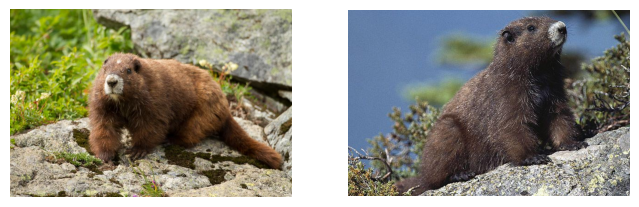

In [72]:
trip1 = dataset.get_triplet(0)
visualize_triplet(trip1)

Give bright colour contrast to the picture with plain white background effect


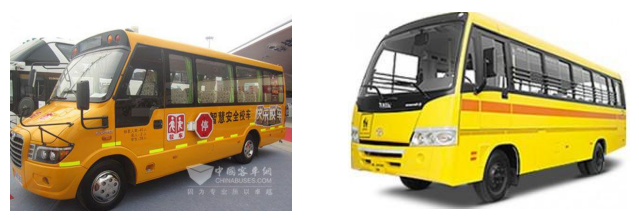

In [82]:
trip2 = dataset.get_triplet(1)
visualize_triplet(trip2)

In [85]:
pipeline.to(device)

target_1 = pipeline(trip1['source_image_embeddings'].to(device), trip1['caption_embeddings'].to(device))
target_2 = pipeline(trip2['source_image_embeddings'].to(device), trip2['caption_embeddings'].to(device))

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [87]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
output_1 = cos(target_1, trip1['target_image_embeddings'])
output_2 = cos(target_2, trip2['target_image_embeddings'])

print(output_1, output_2)

tensor([0.4716], device='cuda:4') tensor([0.5104], device='cuda:4')


In [88]:
output_3 = cos(target_1, trip2['target_image_embeddings'])
output_4 = cos(target_2, trip1['target_image_embeddings'])

print(output_3, output_4)

tensor([0.5152], device='cuda:4') tensor([0.4705], device='cuda:4')


In [15]:
!nvidia-smi

Wed Nov 15 14:40:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   32C    P0    89W / 400W |  15133MiB / 81251MiB |     92%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   